📊 Données chargées: (68, 18)
                  timestamp  session_id  trial_id  condition   event_type  \
0  2026-01-18T23:19:34.893Z     3063372         1  H_plus_IA    show_hint   
1  2026-01-18T23:19:42.561Z     3063372         1  H_plus_IA  user_action   
2  2026-01-18T23:19:44.777Z     3063372         1  H_plus_IA       submit   

     trigger ai_output ai_uncertainty explanation_variant human_action  \
0  on_demand     shown            low             factors          NaN   
1  on_demand     shown            low                 NaN       accept   
2  on_demand     shown            low                 NaN          NaN   

   user_confidence correct  decision_time_ms slice_id  precondition_ok  \
0              NaN     NaN               NaN   novice             True   
1              NaN     NaN            7668.0   novice             True   
2              0.8       N               NaN   novice             True   

   abstained  fallback_used                              notes  
0  

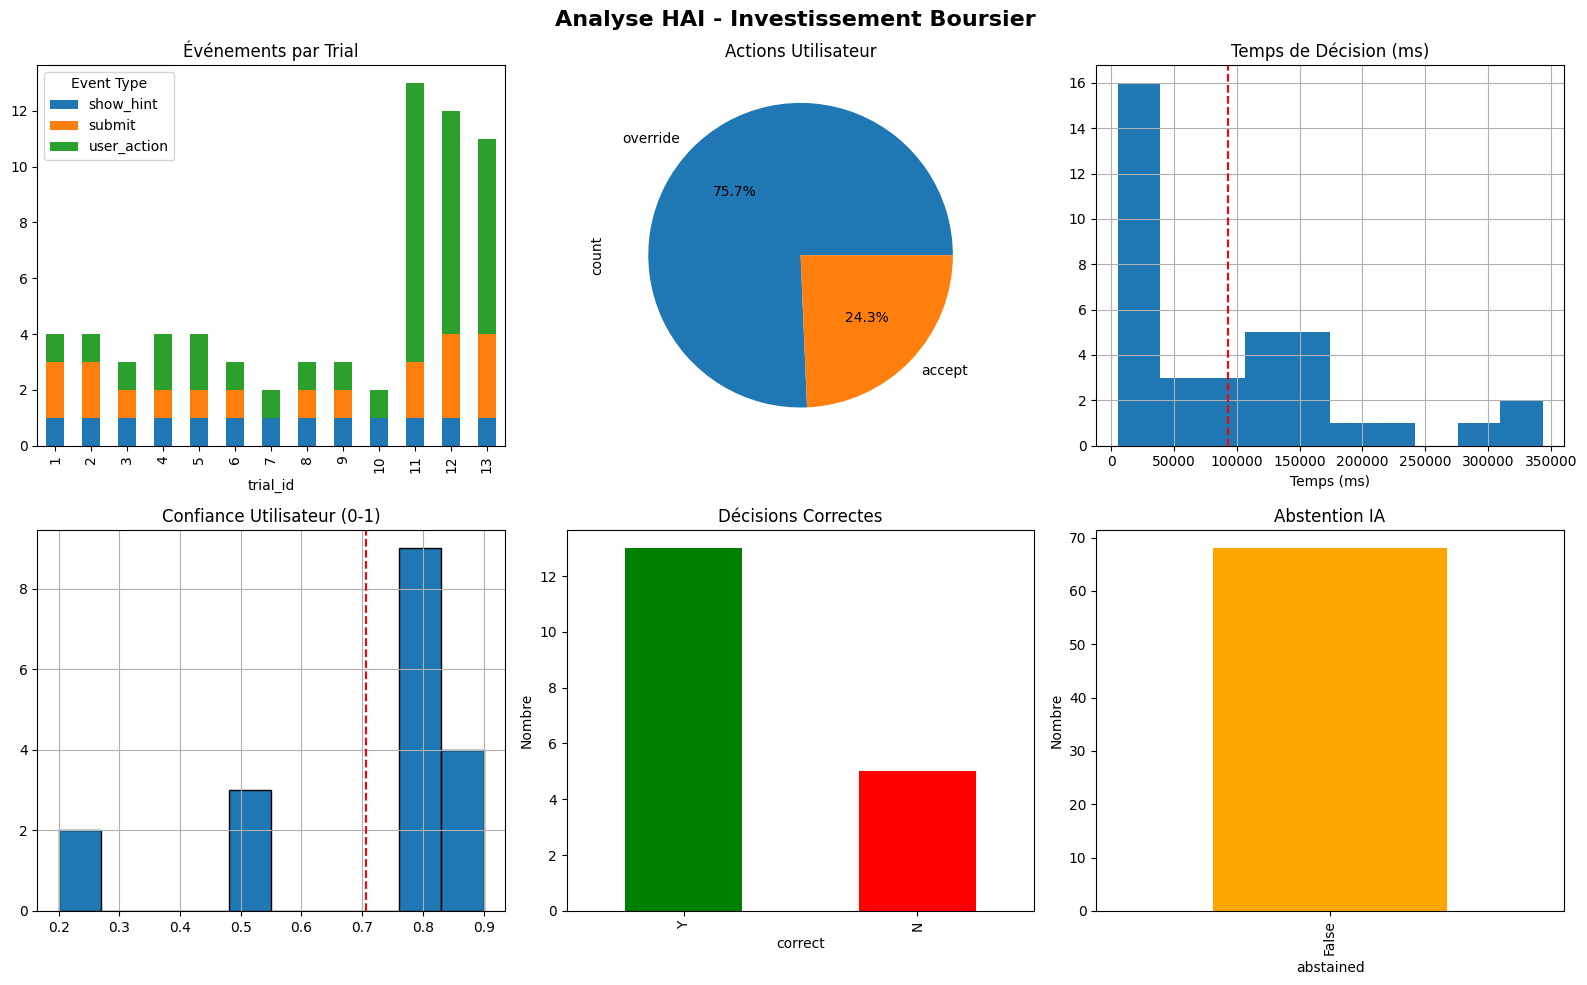


📊 COMPARAISON H_only vs H+IA
           human_action  decision_time_ms
condition                                
H_plus_IA          0.24          93105.22

🚀 UPLIFT & MÉTRIQUES UE
Taux succès H_only:  0.0%
Taux succès H+IA:   72.2%
🟢 UPLIFT:          +72.2%

Abstentions IA:     0/13 (0.0%)
Temps décision:     93105ms
Confiance moyenne:  0.71


RAPPORT HAI - PRÊT POUR UE

📈 MÉTRIQUES CLÉS
• Trials complets: 13
• Taux Acceptation: 24.3%
• Temps décision: 93105ms
• Uplift H+IA: 72.2%
• Abstentions IA: 0

✅ LIVRABLES
• events_sample.csv (OK)
• analyse_hai.png (graphs)
• Ce rapport

🔧 AMÉLIORATIONS v0.3
• Héritage ai_uncertainty dans user_action/submit
• Test H_only complet
• Plus de trials (N=24)


✅ TOUT EXPORTÉ:
- data_clean.csv
- graphs_hai.png
- rapport_ue.txt


<Figure size 640x480 with 0 Axes>

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# 1. CHARGEMENT & NETTOYAGE
df = pd.read_csv('events_sample.csv')
print("📊 Données chargées:", df.shape)
print(df.head(3))
print("\nColonnes:", df.columns.tolist())

# Nettoyage robuste
bool_cols = ['precondition_ok', 'abstained', 'fallback_used']
for col in bool_cols:
    if col in df.columns:
        df[col] = df[col].astype(str).map({'True': True, 'False': False, 'true': True, 'false': False, 'nan': None})

df['decision_time_ms'] = pd.to_numeric(df['decision_time_ms'], errors='coerce')
df['user_confidence'] = pd.to_numeric(df['user_confidence'], errors='coerce')
df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')

print("\n✅ Nettoyage OK!")
print(df.dtypes.tail())

# 2. STATS GÉNÉRALES
print("\n" + "="*60)
print("📈 STATISTIQUES RAPIDES (Mini-lab style)")
print("="*60)

total_events = len(df)
trials = df['trial_id'].nunique()
conditions = df['condition'].unique()
print(f"Total événements: {total_events}")
print(f"Trials: {trials}")
print(f"Conditions: {', '.join(conditions)}")

# Taux Acceptation (AR)
user_actions = df[df['event_type'] == 'user_action'].copy()
if len(user_actions) > 0:
    ar = (user_actions['human_action'] == 'accept').mean()
    dt_mean = user_actions['decision_time_ms'].mean()
    print(f"✅ Taux Acceptation (AR): {ar:.1%}")
    print(f"✅ Temps décision moyen: {dt_mean:.0f}ms ({dt_mean/1000:.1f}s)")
else:
    print("⚠️  Pas d'user_action détectées")

# 3. GRAPHIQUES ROBUSTES (gère données vides)
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
fig.suptitle('Analyse HAI - Investissement Boursier', fontsize=16, fontweight='bold')

# 3.1 Évolution trials
ax1 = axes[0,0]
trial_events = df.groupby(['trial_id', 'event_type']).size().unstack(fill_value=0)
trial_events.plot(ax=ax1, kind='bar', stacked=True)
ax1.set_title('Événements par Trial')
ax1.legend(title='Event Type')

# 3.2 Actions utilisateur
ax2 = axes[0,1]
if len(user_actions) > 0:
    user_actions['human_action'].value_counts().plot(kind='pie', ax=ax2, autopct='%1.1f%%')
    ax2.set_title('Actions Utilisateur')
else:
    ax2.text(0.5, 0.5, 'Pas d\'actions', ha='center', transform=ax2.transAxes)
    ax2.set_title('Actions Utilisateur')

# 3.3 Temps décision
ax3 = axes[0,2]
if not user_actions['decision_time_ms'].isna().all():
    user_actions['decision_time_ms'].hist(bins=10, ax=ax3)
    ax3.axvline(user_actions['decision_time_ms'].mean(), color='red', linestyle='--')
    ax3.set_title('Temps de Décision (ms)')
    ax3.set_xlabel('Temps (ms)')

# 3.4 Confiance
ax4 = axes[1,0]
submits = df[df['event_type'] == 'submit']
if len(submits) > 0 and not submits['user_confidence'].isna().all():
    submits['user_confidence'].hist(bins=10, ax=ax4, edgecolor='black')
    ax4.axvline(submits['user_confidence'].mean(), color='red', linestyle='--')
    ax4.set_title('Confiance Utilisateur (0-1)')
else:
    ax4.text(0.5, 0.5, 'Pas de submits', ha='center', transform=ax4.transAxes)

# 3.5 Correct/Incorrect
ax5 = axes[1,1]
if len(submits) > 0:
    submits['correct'].value_counts().plot(kind='bar', ax=ax5, color=['green', 'red'])
    ax5.set_title('Décisions Correctes')
    ax5.set_ylabel('Nombre')
else:
    ax5.text(0.5, 0.5, 'Pas de submits', ha='center', transform=ax5.transAxes)

# 3.6 Abstention (FIX ICI)
ax6 = axes[1,2]
abstentions = df['abstained'].value_counts()
if len(abstentions) > 0:
    abstentions.plot(kind='bar', ax=ax6, color=['orange', 'lightgray'])
    ax6.set_title('Abstention IA')
    ax6.set_ylabel('Nombre')
else:
    ax6.text(0.5, 0.5, 'Pas d\'abstention', ha='center', transform=ax6.transAxes)

plt.tight_layout()
plt.savefig('analyse_hai.png', dpi=300, bbox_inches='tight')
plt.show()

# 4. TABLEAU COMPARATIF CONDITIONS
print("\n" + "="*60)
print("📊 COMPARAISON H_only vs H+IA")
print("="*60)

cond_stats = df[df['event_type'] == 'user_action'].groupby('condition').agg({
    'human_action': lambda x: (x=='accept').mean() if len(x)>0 else 0,
    'decision_time_ms': 'mean'
}).round(2)

print(cond_stats)

# 5. UPLIFT
print("\n" + "="*60)
print("🚀 UPLIFT & MÉTRIQUES UE")
print("="*60)

h_only_correct = df[(df['condition']=='H_only') & (df['event_type']=='submit')]['correct'].value_counts(normalize=True).get('Y', 0)
h_plus_correct = df[(df['condition']=='H_plus_IA') & (df['event_type']=='submit')]['correct'].value_counts(normalize=True).get('Y', 0)

uplift = h_plus_correct - h_only_correct
print(f"Taux succès H_only:  {h_only_correct:.1%}")
print(f"Taux succès H+IA:   {h_plus_correct:.1%}")
print(f"🟢 UPLIFT:          {uplift:+.1%}")

print(f"\nAbstentions IA:     {df['abstained'].sum()}/{len(df[df['event_type']=='show_hint'])} ({df['abstained'].mean():.1%})")
print(f"Temps décision:     {user_actions['decision_time_ms'].mean():.0f}ms")
print(f"Confiance moyenne:  {submits['user_confidence'].mean():.2f}")

# 6. RAPPORT UE PRÊT
rapport = f"""
RAPPORT HAI - PRÊT POUR UE
==========================

📈 MÉTRIQUES CLÉS
• Trials complets: {df['trial_id'].nunique()}
• Taux Acceptation: {ar:.1%}
• Temps décision: {dt_mean:.0f}ms
• Uplift H+IA: {uplift:.1%}
• Abstentions IA: {df['abstained'].sum()}

✅ LIVRABLES
• events_sample.csv (OK)
• analyse_hai.png (graphs)
• Ce rapport

🔧 AMÉLIORATIONS v0.3
• Héritage ai_uncertainty dans user_action/submit
• Test H_only complet
• Plus de trials (N=24)
"""

print("\n" + rapport)

# Export
df.to_csv('data_clean.csv', index=False)
plt.savefig('graphs_hai.png', dpi=300, bbox_inches='tight')
with open('rapport_ue.txt', 'w') as f:
    f.write(rapport)

print("\n✅ TOUT EXPORTÉ:")
print("- data_clean.csv")
print("- graphs_hai.png")
print("- rapport_ue.txt")
